# Model evaluation

In this notebook, I will compare the accuracy metrics of models

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import scienceplots  # noqa # pylint: disable=unused-import

plt.style.use(["science", "ieee", "default"])
plt.rcParams.update({"axes.grid": True})

In [4]:
from tqdm.auto import tqdm

## Prepare dataloader

In [5]:
from pathlib import Path

ROOT_DATA_DIR = Path("../data/")

In [6]:
from collections import defaultdict

import torch
from pytorch_lightning import Trainer, seed_everything
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from torch import Tensor, nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import get_metrics


def seed_init_fn(seed=1):
    import random

    import numpy as np
    import torch

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x_batch, y_batch) in enumerate(dataloader):
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return res_dict


def test_loop(dataloader, model, loss_fn):
    res_dict = {}
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            y_pred = model(x_batch)
            test_loss += loss_fn(y_pred, y_batch).item()
            all_y.append(y_batch)

            # convert sigmoid to labels
            y_pred = y_pred.reshape(-1)
            y_pred = (y_pred > 0.5).int()
            all_y_pred.append(y_pred)

    test_loss /= num_batches
    res_dict["loss"] = test_loss
    all_y = torch.cat(all_y)
    all_y_pred = torch.cat(all_y_pred)
    res_dict = res_dict | get_metrics(y_true=all_y, y_pred=all_y_pred)
    return res_dict

take only 1 dataset, 1 concrete time series for now...

In [15]:
DATA_DIR = ROOT_DATA_DIR / "KPI-Anomaly-Detection/Preliminary_dataset"

In [16]:
df = pd.read_parquet(DATA_DIR / "train.parquet")
df.rename(columns={"label": "target"}, inplace=True)
df = df[df["KPI ID"] == "02e99bd4f6cfb33f"].copy()
df = df[df.index > 1.49 * 1e9].copy()
df = df.query("timestamp < 1496538120").copy()
df["time"] = df.index - df.index[0]
# df["value"] = df["value"].diff()
# df = df.query('stock==1 & day==0 & train==1')
# df.value = df.value.pct_change()
df.dropna(inplace=True)

In [17]:
def convert_to_windows(x, window_size):
    # convert input time series x to
    # time series of lags, first window_size observations are dropped
    windows = []
    for i in range(window_size, len(x)):
        w = x[i - window_size : i]
        windows.append(w)
    windows = np.array(windows)
    return windows


# TODO: maybe make this a general function...
t = df.copy()
# # for col in ['value', 'target']:
# for col in ["value"]:
#     for lag in range(0, window_size):
#         t[f"lag_{col}_{lag}"] = t[col].shift(lag)
# t = t.dropna()
# tr_cols = [c for c in t.columns if "lag" in c]
# # remove target from train columns
# try:
#     tr_cols.pop(tr_cols.index("lag_target_0"))
# except:
#     pass
# df = t

In [18]:
df["value_diff"] = df["value"].diff()
tr_cols = ["value", "value_diff"]
df = df.dropna()

In [19]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.plot(df.value.diff())
# plt.subplot(1, 2, 2)
# plt.hist(df.value)
# plt.yscale("log")
# plt.tight_layout();

In [20]:
window_size = 8
train_proportion = 0.9
batch_size = 16
learning_rate = 1e-5
epochs = 30

In [21]:
x = df[tr_cols].values.copy()
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
# x_scaled = x
x = convert_to_windows(x, window_size)
y = df["target"].values
y = y[window_size:]

# class_weights = compute_class_weight('balanced', classes=[0, 1], y=y.ravel())
# class_weights = class_weights / class_weights.sum()

x = torch.Tensor(x)
y = torch.Tensor(y)

train_idx = int(len(x) * train_proportion)
# train_idx = int(1.495 * 1e9)

tr, va = x[:train_idx], x[train_idx:]
# x = np.hstack([x, y.reshape(-1, 1)])
# y = y.reshape(-1, 1)
ytr, yva = y[:train_idx], y[train_idx:]
tr_dataset = TensorDataset(tr, ytr)
va_dataset = TensorDataset(va, yva)

# weights = torch.where(ytr.ravel() == 0, class_weights[0], class_weights[1])

# TODO: maybe add test dataset

# debug print
# print(ytr.mean(), yva.mean())

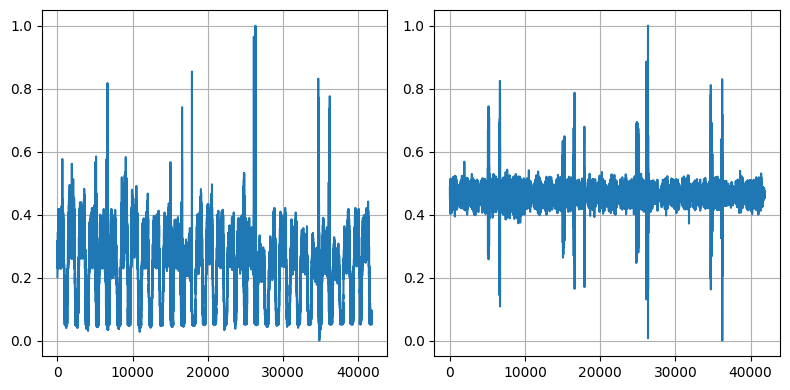

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])
plt.plot(tr[:, 0, 0])
plt.sca(axs[1])
plt.plot(tr[:, 0, 1])
fig.tight_layout();

## Evaluate models

In [52]:
from src.transformer import TransformerAnomalyDetector, TransformerEncoder

### Scaled Dot-Product

In [24]:
seed_everything(1)

# TODO: sampling might be useful for some datasets
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
# tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False, sampler=sampler)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=True)

Global seed set to 1


> **TODO**: add positional enocding

See the code for Anomaly BERT -> implement sequences windows for tensors -> unsqueeze before supplying to the model

In [41]:
input_dim = len(tr_cols)
out_dim = 1

num_layers = 2
block_input_dim = 16
block_embed_dim = block_input_dim  # implicitly set in the block
block_num_heads = 4
block_dim_feedforward = 2 * block_input_dim
block_args = {
    "input_dim": block_input_dim,
    "num_heads": block_num_heads,
    "dim_feedforward": block_dim_feedforward,
}

tf_enc = TransformerEncoder(num_layers=num_layers, **block_args)
# xx = torch.rand(batch_size, window_size, input_dim)

# front_linear = nn.Linear(input_dim, block_input_dim)
# last_linear = nn.Linear(block_input_dim, out_dim)
# xx = front_linear(xx)
# xx = tf_enc(xx)
# last_linear(xx).shape

In [63]:
window_size = 8
train_proportion = 0.9
batch_size = 16
epochs = 25

In [64]:
seed_everything(1)

input_dim = len(tr_cols)

block_args = {
    "input_dim": 16,
    "num_heads": 4,
    "dim_feedforward": 2 * 16,
    "num_layers": 2,
}
positional_encoder_args = {
    "enable": False,
    "max_len": window_size,
}

# convert the above params to a dict
model_params = {
    "input_dim": input_dim,
    "block_input_dim": block_args["input_dim"],
    "block_args": block_args,
    "num_layers": block_args["num_layers"],
    "positional_encoder_args": positional_encoder_args,
    "learning_rate": 1e-5,
    "dropout": 0.0,
}

model = TransformerAnomalyDetector(
    **model_params,
)

Global seed set to 1


In [65]:
# xx = torch.rand(batch_size, window_size, input_dim)
# print(xx.shape)
# model(xx)

In [66]:
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [69]:
seed_everything(1)

res_dict = {}
res_dict["tr_metrics"] = []
res_dict["va_metrics"] = []
verbose = True
for epoch in tqdm(range(epochs)):
    if verbose:
        print(epoch)
    _ = train_loop(
        dataloader=tr_dl,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
    )
    curr_metrics = test_loop(dataloader=tr_dl, model=model, loss_fn=loss_fn)
    if verbose:
        print("train", curr_metrics)
    res_dict["tr_metrics"].append(curr_metrics)
    curr_metrics = test_loop(dataloader=va_dl, model=model, loss_fn=loss_fn)
    if verbose:
        print("val", curr_metrics)
    res_dict["va_metrics"].append(curr_metrics)

    if verbose:
        print()  # empty line

res_dict["tr_metrics"] = pd.DataFrame(res_dict["tr_metrics"])
res_dict["va_metrics"] = pd.DataFrame(res_dict["va_metrics"])

Global seed set to 1


  0%|          | 0/25 [00:00<?, ?it/s]

0
train {'loss': 0.14725280885229083, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}
val {'loss': 0.28004794747046996, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}

1
train {'loss': 0.14597145549086504, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}
val {'loss': 0.2772395965736039, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}

2
train {'loss': 0.14459620328803918, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}
val {'loss': 0.27484904204677674, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}

3
train {'loss': 0.14308573118130966, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}
val {'loss': 0.27215505089239567, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}

4
train {'loss': 0.1414111102492974, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}
val {'loss': 0.2695851412784193, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'f1': 0.0}

5
train {'loss': 0.13955908123825625, 'precision': 0.0, 'recall': 0.0, 'auc': 

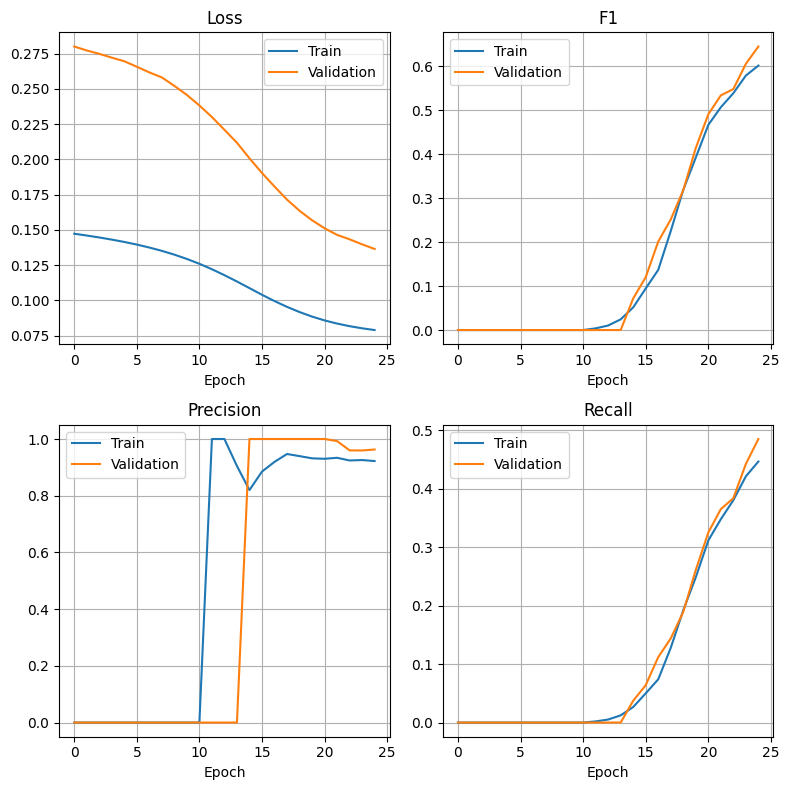

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res_dict["tr_metrics"]["loss"], label="Train")
plt.plot(res_dict["va_metrics"]["loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res_dict["tr_metrics"]["f1"], label="Train")
plt.plot(res_dict["va_metrics"]["f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res_dict["tr_metrics"]["precision"], label="Train")
plt.plot(res_dict["va_metrics"]["precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res_dict["tr_metrics"]["recall"], label="Train")
plt.plot(res_dict["va_metrics"]["recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();

## Linear attention

implementation: https://github.com/idiap/fast-transformers

paper: https://arxiv.org/pdf/2006.16236.pdf

In [272]:
from src.transformer import LinearTransformer

In [273]:
window_size = 8
train_proportion = 0.9
batch_size = 16
learning_rate = 1e-3 / 2
epochs = 30

input_dim = len(tr_cols)
embed_dim = 8
num_heads = 1

In [283]:
seed_everything(1)

# TODO: sampling might be useful for some datasets
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
# tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False, sampler=sampler)

tr_dl = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
va_dl = DataLoader(va_dataset, batch_size=batch_size, shuffle=True)

Global seed set to 1


In [284]:
seed_everything(1)
model = LinearTransformer(input_dim=input_dim, num_heads=num_heads, embed_dim=embed_dim)

Global seed set to 1


In [276]:
model

LinearTransformer(
  (linear_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): LinearAttention(
            (feature_map): ActivationFunctionFeatureMap()
          )
          (query_projection): Linear(in_features=8, out_features=8, bias=True)
          (key_projection): Linear(in_features=8, out_features=8, bias=True)
          (value_projection): Linear(in_features=8, out_features=8, bias=True)
          (out_projection): Linear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_features=8, bias=True)
        (linear2): Linear(in_features=8, out_features=8, bias=True)
        (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)

In [277]:
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [278]:
seed_everything(1)

res_dict = {}
res_dict["tr_metrics"] = []
res_dict["va_metrics"] = []
verbose = True
for epoch in tqdm(range(epochs)):
    if verbose:
        print(epoch)
    _ = train_loop(
        dataloader=tr_dl,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
    )
    curr_metrics = test_loop(dataloader=tr_dl, model=model, loss_fn=loss_fn)
    if verbose:
        print("train", curr_metrics)
    res_dict["tr_metrics"].append(curr_metrics)
    curr_metrics = test_loop(dataloader=va_dl, model=model, loss_fn=loss_fn)
    if verbose:
        print("val", curr_metrics)
    res_dict["va_metrics"].append(curr_metrics)

    if verbose:
        print()  # empty line

res_dict["tr_metrics"] = pd.DataFrame(res_dict["tr_metrics"])
res_dict["va_metrics"] = pd.DataFrame(res_dict["va_metrics"])

  0%|          | 0/30 [00:00<?, ?it/s]

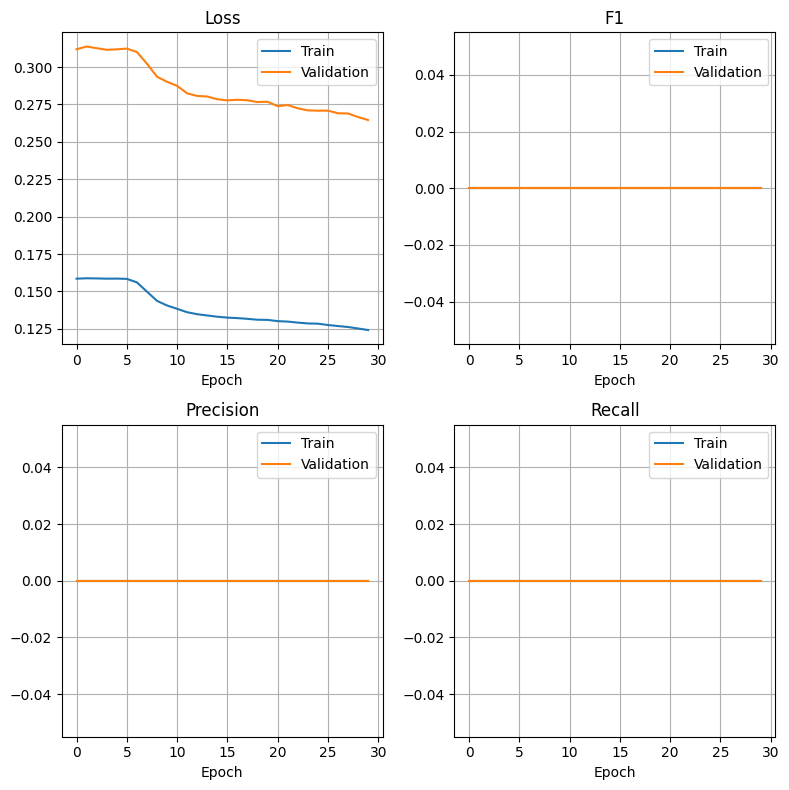

In [279]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
plt.plot(res_dict["tr_metrics"]["loss"], label="Train")
plt.plot(res_dict["va_metrics"]["loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[0, 1])
plt.plot(res_dict["tr_metrics"]["f1"], label="Train")
plt.plot(res_dict["va_metrics"]["f1"], label="Validation")
plt.title("F1")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 0])
plt.plot(res_dict["tr_metrics"]["precision"], label="Train")
plt.plot(res_dict["va_metrics"]["precision"], label="Validation")
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend()
plt.sca(axs[1, 1])
plt.plot(res_dict["tr_metrics"]["recall"], label="Train")
plt.plot(res_dict["va_metrics"]["recall"], label="Validation")
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend()
fig.tight_layout();